# 22 - Latent Dirichlet Allocation - Ejemplo Topics & Terms en Tweets Políticos


* En este Notebook vamos a agrupar los tweets publicados por los partidos políticos y los políticos para ver si verdaderamente el LDA es capaz de diferenciar las 5 tendencias políticas (5 Topics) que hay en estos tweets.


* Por otro lado tambien es interesante ver cuales son las palabras (Terms) característicos de cada uno de estos Topics.


* Para ello vamos a realizar los siguientes pasos:

    1. Carga de datos
    2. Normalizar los tweets (igual que en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb*)
    3. Creacción del diccionario y la bolsa de palabras
    4. Selección del número óptimo de Topics
    5. Creacción del Modelo
    6. Visualización

<hr>


## Carga de Datos


* El fichero que contiene los tweets lo podemos leer como un '*csv*' con pandas pasandole como separador '***::::***'.


* Este fichero esta estructurado de la siguiente manera
    - **Cuenta**: Cuenta de twitter
    - **Partido**: Partido político al que pertenece (ciudadanos, podemos, pp, psoe)
    - **Timestamp**: Instante en el que se publicó el tweet
    - **Tweet**: Tweet.
    
    
* Leemos los datos y mostramos una muestra:

In [1]:
import warnings
warnings.filterwarnings('ignore')
import datetime
import time
import pandas as pd

TWEETS_FILE = './data/tweets_politica.csv'
df = pd.read_csv(TWEETS_FILE, sep='::::', engine='python')

# Eliminamos los tweets que tengan algún valor a nulo
df = df.dropna()
print('Número de Tweets Cargados: {num}'.format(num=df.shape[0]))

# Filtramos los tweets a partir de una fecha
DATE = "01/01/2021"
timestamp = time.mktime(datetime.datetime.strptime(DATE, "%d/%m/%Y").timetuple())
df = df[df.timestamp >= timestamp]

# Nos quedamos solo con el nombre del partido y el tweet
tweets = [tuple(x) for x in df[['tweet', 'partido']].values]

# Imprimimos el número de tweets a procesar
print('Número de Tweets a procesar: {num}'.format(num=df.shape[0]))
df.sample(10)

Número de Tweets Cargados: 96017
Número de Tweets a procesar: 23781


,cuenta,partido,timestamp,tweet
77519,isaserras,podemos,1.611668e+09,Violencia e insultos contra las mujeres que da...
88736,PSOE,psoe,1.615893e+09,Mañana comparece #Bárcenas en la comisión de i...
90373,vox_es,vox,1.616399e+09,🔊 A las 12:00 comenzará la rueda de prensa de ...
94213,ignacioaguado,ciudadanos,1.617630e+09,Hoy hemos celebrado una nueva reunión del Comi...
77096,hermanntertsch,vox,1.611780e+09,"Aquí los tienen, a los “hombres de la cultura”..."
76742,DolorsMM,pp,1.611394e+09,Se cumplen 26 años del asesinato de Gregorio O...
86322,LopezMirasF,pp,1.614972e+09,Trabajemos juntos por la igualdad cada día. Si...
72826,eledhmel,vox,1.609929e+09,"""... y cayendo de rodillas, le adoraron"". Mate..."
89284,isaserras,podemos,1.615804e+09,Gracias @PabloIglesias. Qué orgullo.¡Vamos a p...
78399,sanchezcastejon,psoe,1.612168e+09,España condena el golpe de Estado en Myanmar. ...


<hr>


## Normalización

* Utilizamos ***spaCy*** para la tokenización y normalización.


* Tras realizar un análisis del contenido de los tweets pasamos a realizar las siguientes acciones para ***normalizar*** los tweets:
    1. Pasamos las frases a minúsculas.
    2. Sustituimos los puntos por espacios ya que hay muchas palabras unidas por un punto
    3. Quitamos la almuhadilla de los hashtags para considerarlos como palabras.
    4. Eliminamos los signos de puntuación.
    5. Eliminamos las palabras con menos de 3 caracteres.
    6. Eliminamos las Stop-Words.
    7. Eliminamos los enlaces(http) y las menciones (@)
    8. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.


* ***NOTA***: Se pueden realizar más acciones de normalización que las realizadas, como tratamiento de emoticonos, tratamiento especial de referencia a cuentas, hashtags, etc. Al tratarse de un ejemplo didáctica se ha realizado una normalización '*sencilla*'.

In [2]:
import numpy as np
import spacy

from tqdm import tqdm

nlp = spacy.load('es_core_news_sm')

X = [doc[0] for doc in tweets]

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(tqdm(sentenses)):
        # Tokenizamos el tweets realizando los puntos 1,2 y 3.
        sentense = nlp(sentense.lower().replace('.', ' ').replace('#', ' ').strip())
        # Puntos 4,5,6,7 y 8
        sentenses[index] = ([word.lemma_ for word in sentense if (not word.is_punct)
                             and (len(word.text) > 2) and (not word.is_stop)
                             and (not word.text.startswith('@'))
                             and (not word.text.startswith('http'))
                             and (not ':' in word.text)])
    return sentenses

# Normalizamos las frases
X_norm = normalize(X)

100%|██████████| 23781/23781 [02:39<00:00, 149.32it/s]


<hr>


## Creamos el Diccionario y la Matriz (Bolsa de Palabras)

In [3]:
from pprint import pprint
from gensim import corpora
from collections import defaultdict

# Creamos el diccionario (vocabulario)
frequency = defaultdict(int)
for doc in X_norm:
    for token in doc:
        frequency[token] += 1
        
documents = [[token for token in doc] for doc in X_norm]
dictionary = corpora.Dictionary(documents)
print('Diccionario:\n{}'.format(dictionary))


# Creamos la Bolsa de Palabras
corpus = [dictionary.doc2bow(doc) for doc in documents]
print('\nPrimer Documento del Corpus:\n{}'.format(corpus[0]))

Diccionario:
Dictionary(49915 unique tokens: ['atrás', 'cambiar', 'chino', 'comunidad', 'decidir']...)

Primer Documento del Corpus:
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]


<hr>


## Selección del número óptimo de Topics


* Veamos la coherencia para modelos desde 2 a 10 temas (Topics).

In [4]:
warnings.filterwarnings('ignore')
from gensim.models import LdaModel, CoherenceModel

coherence = []
min_topics = 2
max_topics = 11
for num_topics in tqdm(range(min_topics, max_topics, 1)):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=0,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    coherencemodel = CoherenceModel(model=lda_model, texts=X_norm, dictionary=dictionary, coherence='c_uci')
    coherence.append(coherencemodel.get_coherence())
    
index = ["Num Topics: {num}".format(num=num) for num in range(min_topics, max_topics, 1)]
pd.DataFrame(coherence, index=index, columns=['Coherence'])

100%|██████████| 9/9 [13:18<00:00, 88.70s/it]


,Coherence
Num Topics: 2,-1.201297
Num Topics: 3,-0.797484
Num Topics: 4,-1.863847
Num Topics: 5,-1.547741
Num Topics: 6,-1.227775
Num Topics: 7,-2.061701
Num Topics: 8,-1.628719
Num Topics: 9,-2.256685
Num Topics: 10,-2.421590


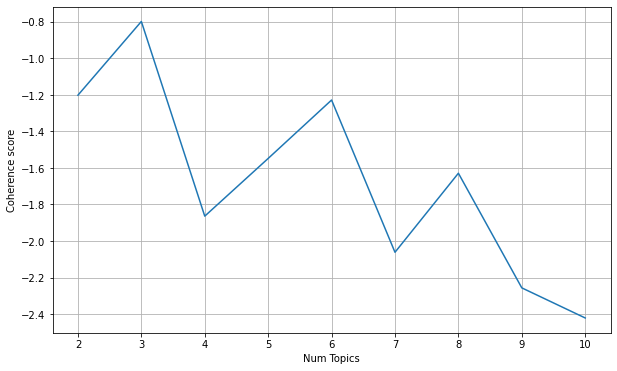

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
plt.plot(range(min_topics, max_topics, 1), coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.grid()
plt.show()

<hr>


## Creamos el Modelo:


* Con la coherencia obtenida, podemos observar que ***6 Topics*** serie un buen número de temas a seleccionar, aunque lo esperado hubiese sido tener 5 Topics correspondientes a 5 tendencias políticas.


* Vamos a crear el modelo con 5 Topics para ver si vemos diferencias entre las 5 tendencias políticas:

In [6]:
from gensim.models import LdaModel

lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=0)

<hr>


## Visualización 5 Topics:

In [7]:
import pyLDAvis
import pyLDAvis.gensim

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

<hr>


## Nube de etiquetas por Tópico


* Utilizando el último modelo generado del LDA, vamos a asignar el tópico al que pertenece cada documento y vamos a generar una nube de palabras por tópico.


* Para ello vamos a obtener el tópico más problable dado un documento, obteniendo las probabilidades de pertenencia al tópico dado por la función "*get_document_topics()*".


* Una vez asignado el tópico al documento creamos la nube de palabras (etiquetas).

/Users/ricardomoyagarcia/opt/anaconda3/envs/Python37_NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


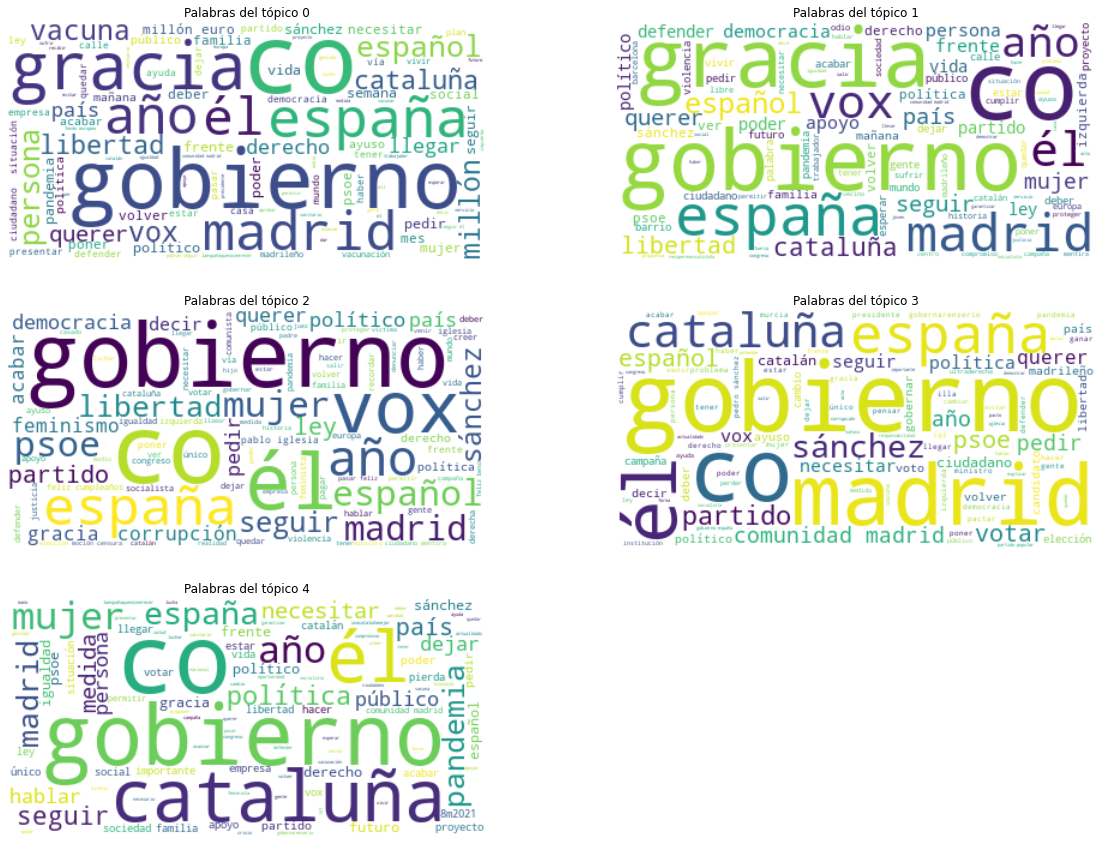

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools
%matplotlib inline


# Obtenemos el tópico más probable para cada documento del corpus
document_topics = [[tup[1] for tup in lst].index(max([tup[1] for tup in lst])) for lst in lda_model[corpus]]


# Procesamiento y pintado de las nubes de etiquetas
plt.figure(figsize=(20, 15))
pos = 1
for topic in set(document_topics):   
    # Obtenemos las palabras por tópico
    words = ' '.join([' '.join(X_norm[i]) for i, x in enumerate(document_topics) if x == topic])
    
    # Pintamos las 5 nubes de etiquetas
    plt.subplot(3, 2, pos)
    wordcloud = WordCloud(max_font_size=80, max_words=100, background_color="white").generate(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Palabras del tópico {}".format(topic))
    pos += 1
plt.show()